<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/quantum-protocols-algos/quantum_walks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q qiskit
!pip install -q pylatexenc
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, transpile
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit_textbook.tools import simon_oracle
import matplotlib.pyplot as plt
import math
from qiskit.quantum_info import Statevector

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, Aer

# import basic plot tools
from qiskit.circuit.library import QFT

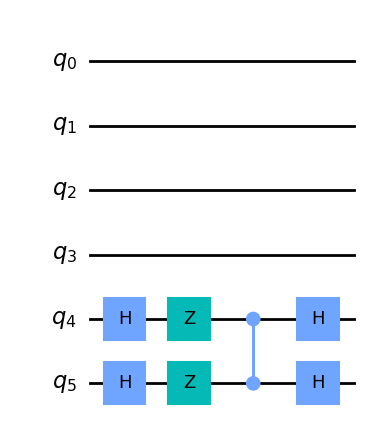

In [ ]:
one_step_circuit = QuantumCircuit(6, name = "One Step")

one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])

one_step_circuit.draw("mpl")

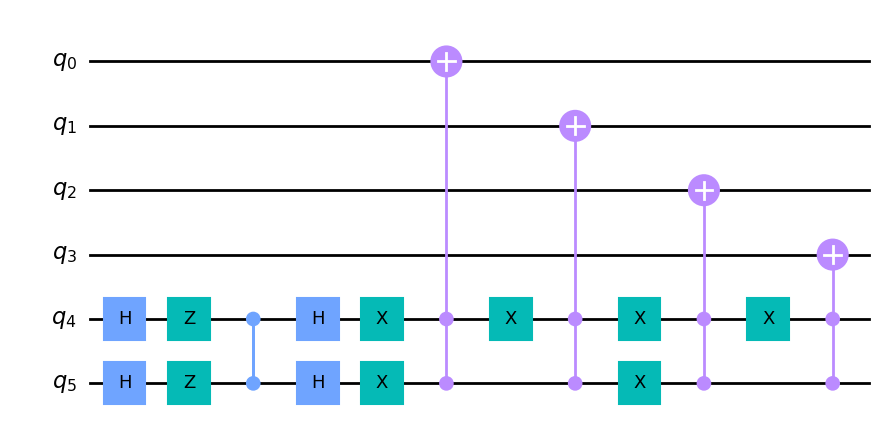

In [ ]:
def shift_operator(circuit):
  for i in range(0,4):
    circuit.x(4)
    if i % 2 == 0:
      circuit.x(5)

    circuit.ccx(4,5,i)

shift_operator(one_step_circuit)
one_step_gate = one_step_circuit.to_instruction()
one_step_circuit.draw("mpl")

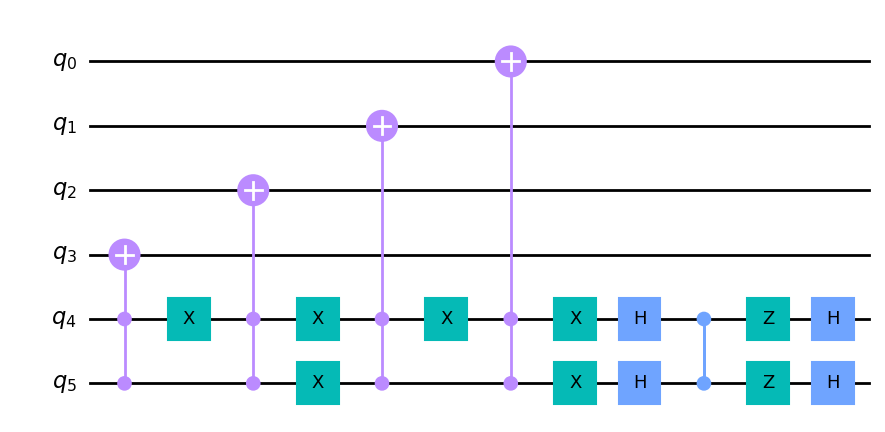

In [ ]:
one_step_circuit.inverse().draw("mpl")

In [ ]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

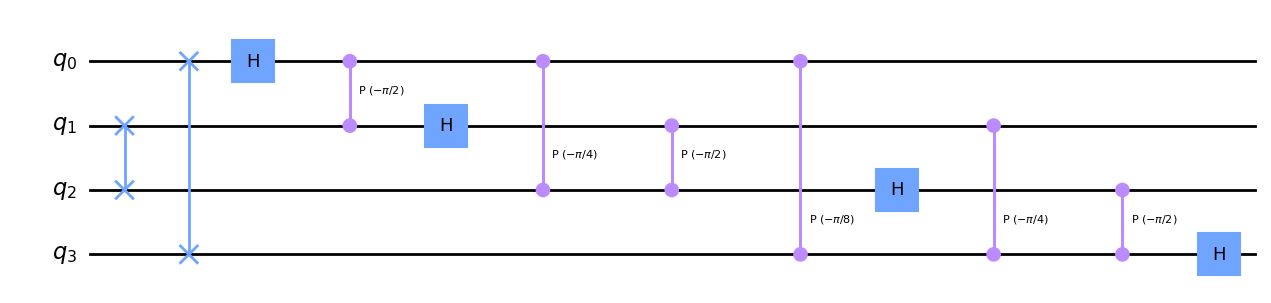

In [ ]:
inv_qft_gate = QFT(4, inverse=True).to_instruction()
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

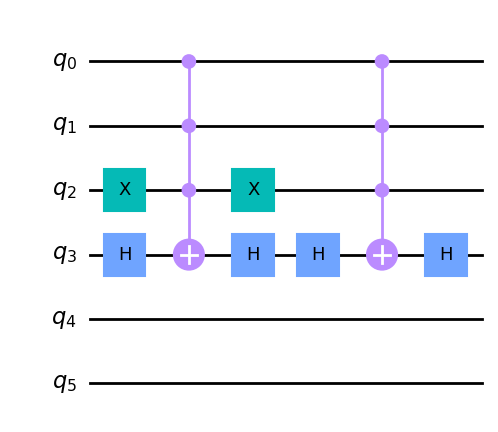

In [ ]:
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Mark 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mct([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)
# Mark 1111
phase_circuit.h(3)
phase_circuit.mct([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw("mpl")

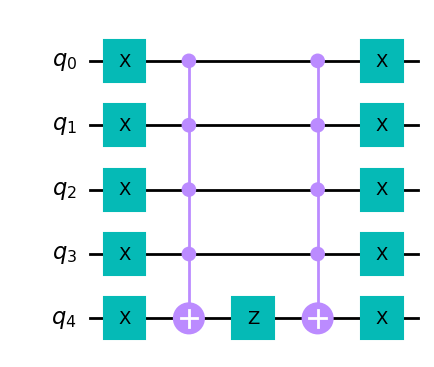

In [ ]:
# Mark q_4 if the other qubits are non-zero
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw("mpl")

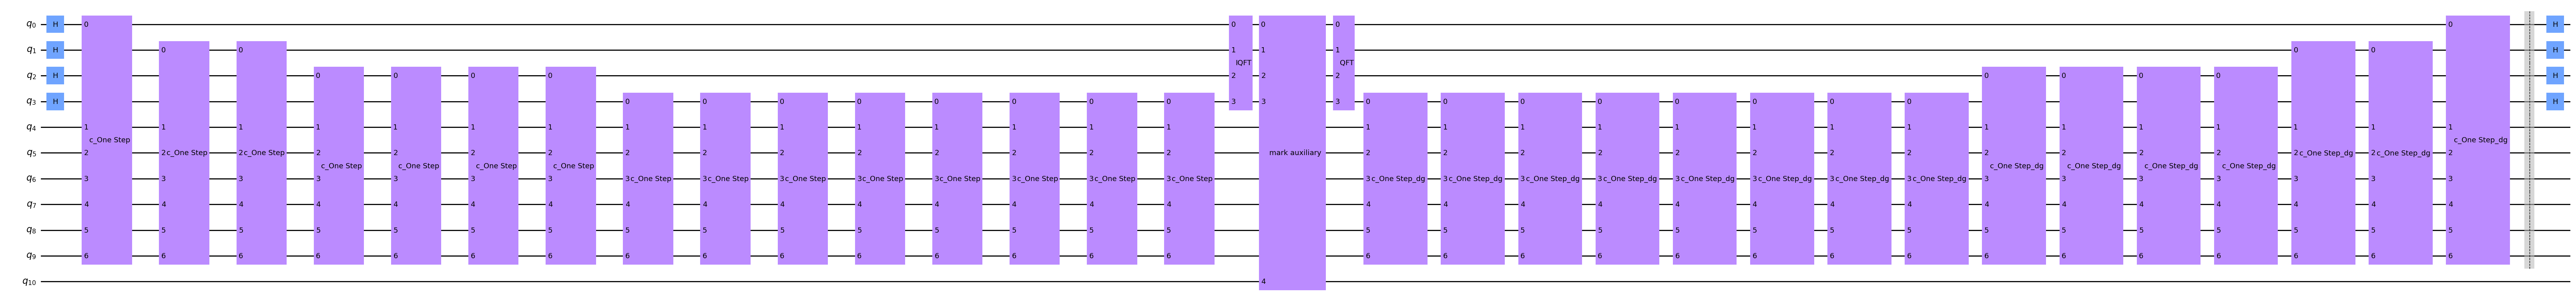

In [ ]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw("mpl", fold = -1)

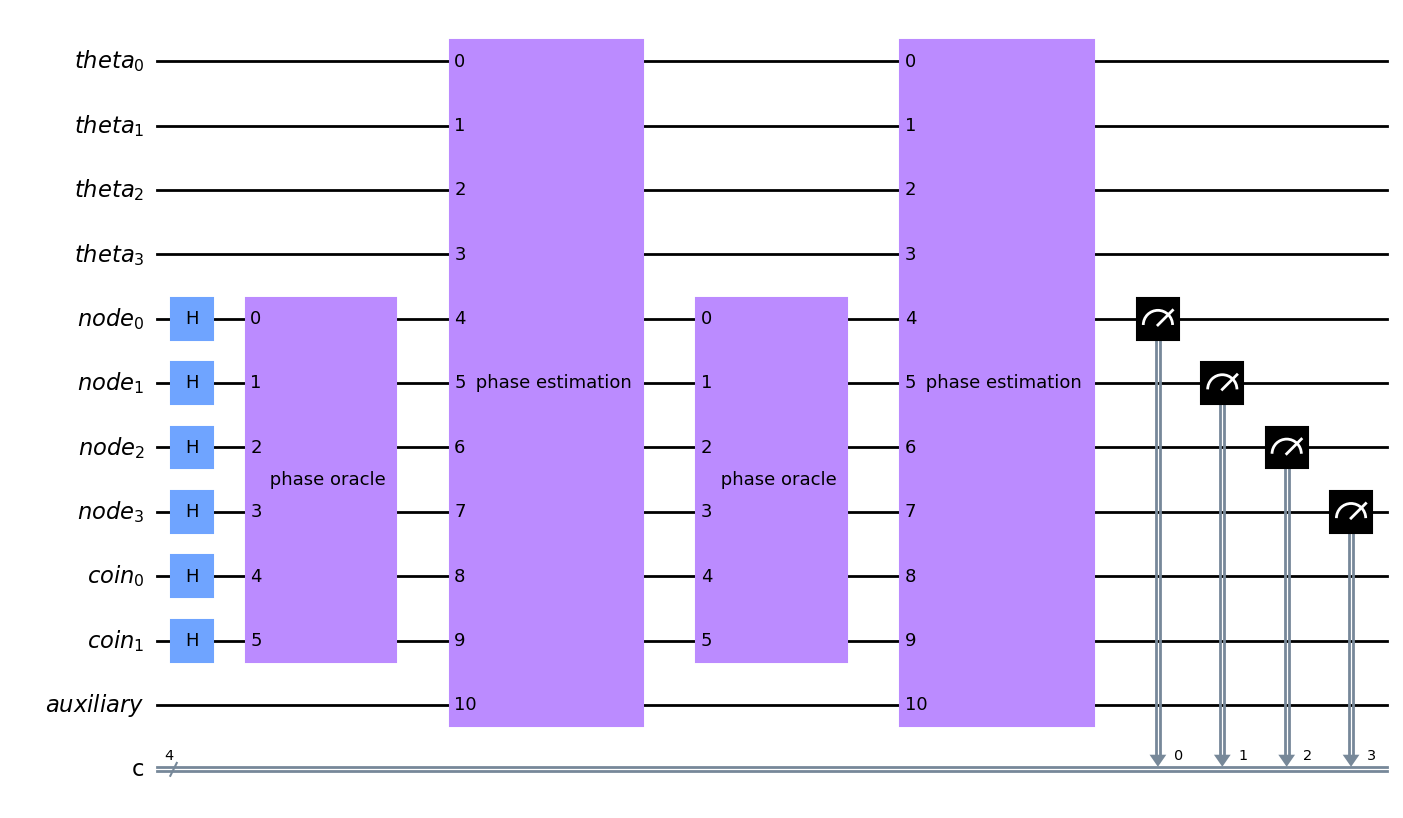

In [ ]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([4,5,6,7,8,9])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw("mpl", fold = -1)

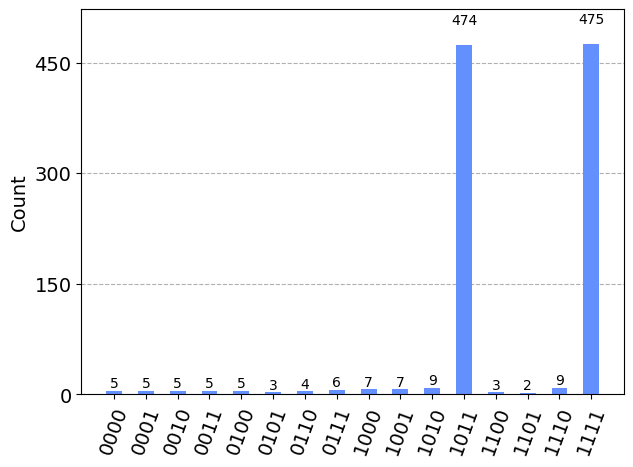

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute( circuit, backend, shots=1024 )
hist = job.result().get_counts()
plot_histogram( hist )